In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning

/content/drive/MyDrive/Colab Notebooks/DeepLearning


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, plot_model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Dropout, Input, BatchNormalization
from keras.models import Model
from keras.losses import categorical_crossentropy
#from keras.optimizers import Adadelta

from sklearn.preprocessing import OneHotEncoder
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import random

from matplotlib.pyplot import cm
from sklearn.decomposition import PCA

In [ ]:
set_random_seed(42)

In [ ]:
with h5py.File('../Kaggle/3D_MNIST/full_dataset_vectors.h5', "r") as hf:    
    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    y_test = hf["y_test"][:]

In [ ]:
print(f'x_train_shape: {X_train.shape}, y_train_shape: {y_train.shape}')
print(f'x_test_shape : {X_test.shape},  y_test_shape : {y_test.shape}')

x_train_shape: (10000, 4096), y_train_shape: (10000,)
x_test_shape : (2000, 4096),  y_test_shape : (2000,)


In [ ]:
x__train = np.ndarray((X_train.shape[0],4096,3))
x__test = np.ndarray((X_test.shape[0],4096,3))

def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(X_train.shape[0]):
    x__train[i] = add_rgb_dimention(X_train[i])
for i in range(X_test.shape[0]):
    x__test[i] = add_rgb_dimention(X_test[i])

x_train = x__train.reshape(X_train.shape[0],16,16,16,3)
x_test = x__test.reshape(X_test.shape[0],16,16,16,3)

ytrain = keras.utils.to_categorical(y_train, 10)
ytest = keras.utils.to_categorical(y_test, 10)
print(x_train.shape,x_test.shape,ytrain.shape , ytest.shape)

(10000, 16, 16, 16, 3) (2000, 16, 16, 16, 3) (10000, 10) (2000, 10)


In [ ]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=1024, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 16, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 14, 14, 14, 16)    1312      
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 12, 12, 64)    27712     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 6, 6, 64)      0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 4, 4, 256)      442624    
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 2, 2, 512)      3539456   
                                                             

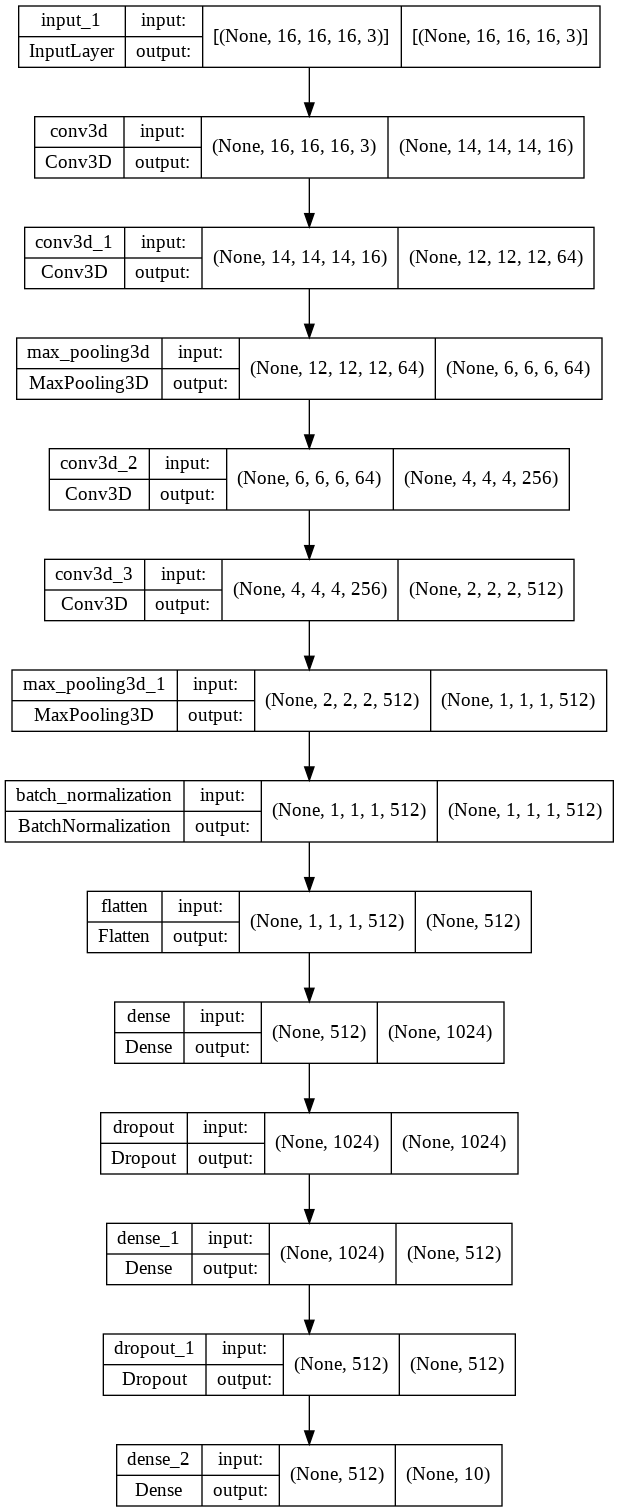

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
his = model.fit(x=x_train, y=ytrain, batch_size=512, epochs=50, validation_split=0.2)

Epoch 1/50
16/16 [==============================] - 9s 295ms/step - loss: 1.7220 - accuracy: 0.3887 - val_loss: 6.2166 - val_accuracy: 0.1050
Epoch 2/50
16/16 [==============================] - 3s 198ms/step - loss: 1.1354 - accuracy: 0.5975 - val_loss: 5.3960 - val_accuracy: 0.1800
Epoch 3/50
16/16 [==============================] - 3s 199ms/step - loss: 0.9404 - accuracy: 0.6701 - val_loss: 4.7175 - val_accuracy: 0.1370
Epoch 4/50
16/16 [==============================] - 3s 200ms/step - loss: 0.8141 - accuracy: 0.7147 - val_loss: 6.2123 - val_accuracy: 0.1050
Epoch 5/50
16/16 [==============================] - 3s 200ms/step - loss: 0.6915 - accuracy: 0.7645 - val_loss: 3.8586 - val_accuracy: 0.1640
Epoch 6/50
16/16 [==============================] - 3s 201ms/step - loss: 0.5473 - accuracy: 0.8138 - val_loss: 3.1148 - val_accuracy: 0.1590
Epoch 7/50
16/16 [==============================] - 3s 203ms/step - loss: 0.4347 - accuracy: 0.8530 - val_loss: 3.8575 - val_accuracy: 0.2005
Epoch 

In [ ]:
preds = model.evaluate(x = x_test, y = ytest)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

63/63 [==============================] - 1s 7ms/step - loss: 121.6612 - accuracy: 0.1100

Loss = 121.66124725341797
Test Accuracy = 0.10999999940395355


In [ ]:
pred =model.predict(x_test)
pred = np.argmax(pred, axis=1)
print(pred,y_test)
count = 0
for i in pred:
    if pred[i] != y_test[i]:
        count += 1
print('total:',len(y_test),'Wrong-pred:',count)

[6 6 6 ... 6 6 6] [7 7 2 ... 8 9 9]
total: 2000 Wrong-pred: 2000


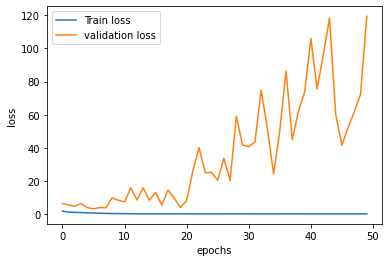

In [ ]:
# loss 비교
plt.plot(his.epoch, his.history['loss'],label='Train loss')
plt.plot(his.epoch, his.history['val_loss'],label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

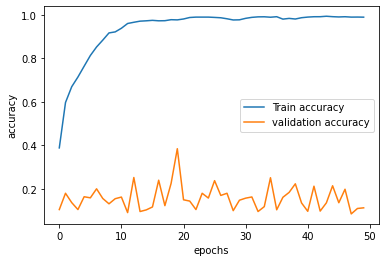

In [ ]:
# accuracy
plt.plot(his.epoch, his.history['accuracy'],label='Train accuracy')
plt.plot(his.epoch, his.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 모델 저장
---

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
M_FILE ='irismodel.h5'
W_FILE ='irisweight.h5'

In [ ]:
if accv >= 0.7:
  save_model(3D_mnist_Model, M_FILE)
  3D_mnist_Model.save_weights(W_FILE)

SyntaxError: ignored